# Ham and Spam E-mail Classifier

## 1. Data Preprocessing

### 1.1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import median
from numpy import var
from scipy.stats import pearsonr
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [2]:
#Disable warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 1.2. DataSet Read
Read data from initial dataset

In [3]:
df = pd.read_csv("spambase/spambase.data", header=None)

In [4]:
y = df[57]

df_np = df.to_numpy()
print(df.describe()[20])


count    4601.000000
mean        0.809761
std         1.200810
min         0.000000
25%         0.000000
50%         0.220000
75%         1.270000
max        11.110000
Name: 20, dtype: float64


In [5]:
dummy = df.values
X = dummy[:,:57]
y = dummy[:,57]

In [6]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3)

In [7]:
# Possible packages
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

# EXAMPLE
### ANOVA..... f_classif option
from sklearn.feature_selection import SelectKBest, f_classif

N=57

k_bestfeatures = SelectKBest(score_func = f_classif)
rankings = k_bestfeatures.fit(X_train,y_train)
b=list(rankings.scores_)
a=list(range(0,len(b)))



sf = [g for _,g in sorted(zip(b,a))]
sf=sf[len(a)-N:len(a)]
c=1
sf=reversed(sf)
print(['order','index','f-score'])
inx=[]
for chosen in sf:
    print(str(c)+'º: ', chosen,'   ', b[chosen])
    c+=1
    inx.append(chosen)
print(inx)

['order', 'index', 'f-score']
1º:  20     507.97516083436693
2º:  6     416.42515430973185
3º:  22     377.88877913901183
4º:  52     361.5101624285268
5º:  18     280.8091690870574
6º:  56     262.8285879339634
7º:  16     233.02395488679025
8º:  8     229.9701716910845
9º:  24     227.24787353995814
10º:  15     217.84695179578833
11º:  4     204.37230061532824
12º:  10     203.6408718085115
13º:  25     190.5780840672063
14º:  5     163.53585943094484
15º:  51     163.01085242315466
16º:  2     146.7451997688395
17º:  7     138.9109337625193
18º:  23     134.7841070857476
19º:  55     131.02279926148847
20º:  17     127.95890967336275
21º:  14     125.98199155153875
22º:  26     116.6770668014064
23º:  36     115.62484127704421
24º:  19     115.61391018515607
25º:  29     107.08573707128022
26º:  34     98.3590201851272
27º:  27     78.48390547928149
28º:  45     73.2314677569256
29º:  12     72.62965489572187
30º:  0     69.92047202984554
31º:  44     64.30732209953713
32º:  41    

### 1.3. Dataset Display
Histogram of samples distribution

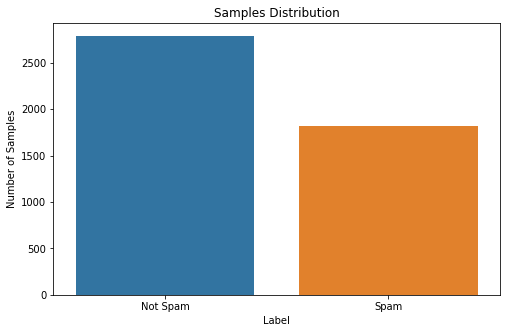

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y)
plt.xlabel("Label")
ax.set_xticklabels(['Not Spam', 'Spam'])
plt.ylabel("Number of Samples")
plt.title("Samples Distribution")
plt.show()


Box plots of features

Mean: 0.10455335796565964
Median: 0.0
Variance: 0.0932229748208258
Range: 4.54


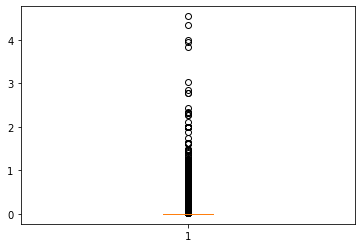

Mean: 0.21301456205172786
Median: 0.0
Variance: 1.6652223186316764
Range: 14.28


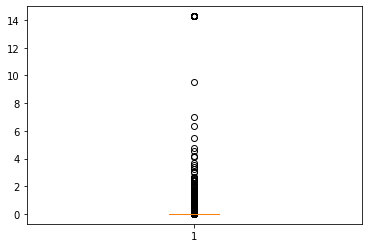

Mean: 0.28065637904803303
Median: 0.0
Variance: 0.25410480715828626
Range: 5.1


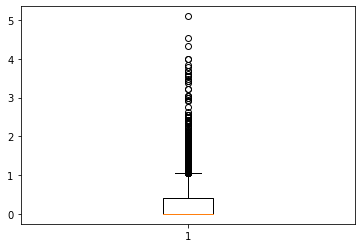

Mean: 0.06542490762877635
Median: 0.0
Variance: 1.9460242978277733
Range: 42.81


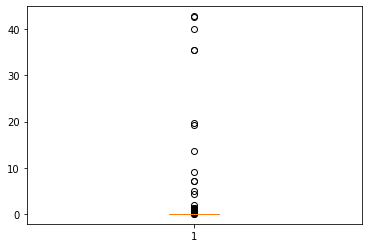

Mean: 0.312223429689198
Median: 0.0
Variance: 0.452175125910515
Range: 10.0


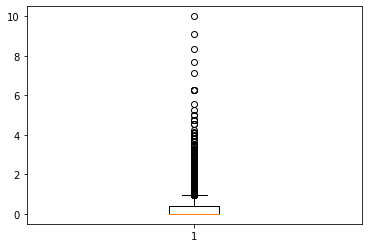

Mean: 0.09590089111062812
Median: 0.0
Variance: 0.07496333205962756
Range: 5.88


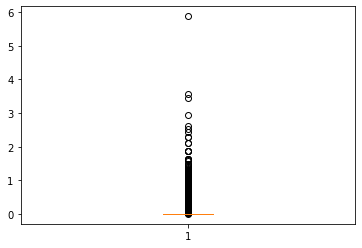

Mean: 0.11420778091719191
Median: 0.0
Variance: 0.15319303137610152
Range: 7.27


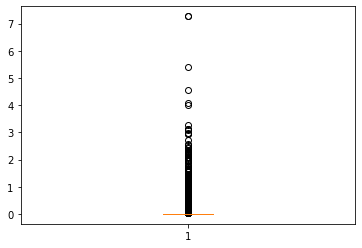

Mean: 0.10529450119539231
Median: 0.0
Variance: 0.1608233483918453
Range: 11.11


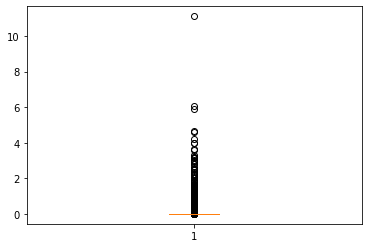

Mean: 0.09006737665724841
Median: 0.0
Variance: 0.07760992808372881
Range: 5.26


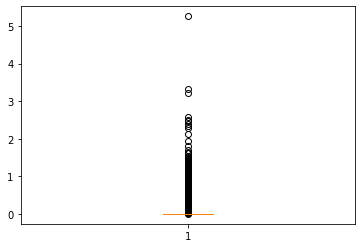

Mean: 0.23941317104977178
Median: 0.0
Variance: 0.41561917312797964
Range: 18.18


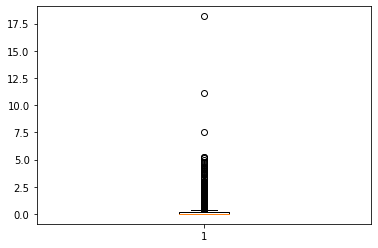

Mean: 0.05982395131493154
Median: 0.0
Variance: 0.04061142303859271
Range: 2.61


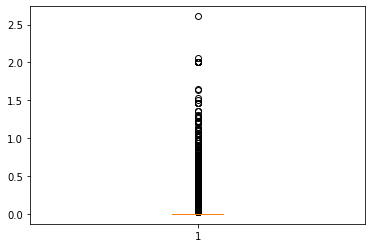

Mean: 0.5417018039556618
Median: 0.1
Variance: 0.7423628721745332
Range: 9.67


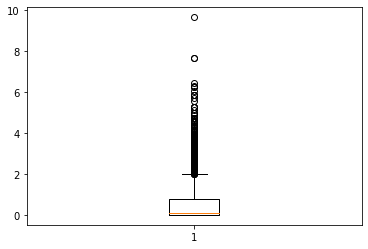

Mean: 0.09392958052597261
Median: 0.0
Variance: 0.0906028587663748
Range: 5.55


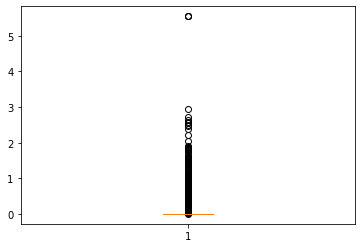

Mean: 0.05862638556835471
Median: 0.0
Variance: 0.11232378151636428
Range: 10.0


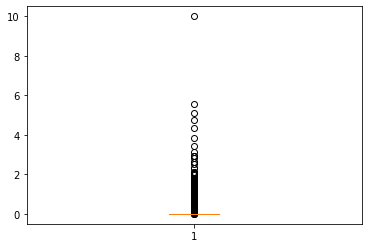

Mean: 0.04920452075635731
Median: 0.0
Variance: 0.0669853702555897
Range: 4.41


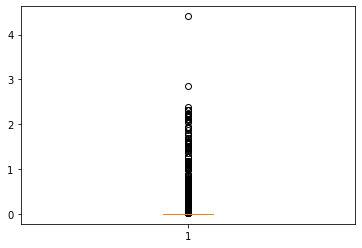

Mean: 0.24884807650510754
Median: 0.0
Variance: 0.6817837198012339
Range: 20.0


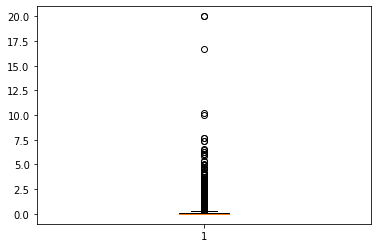

Mean: 0.14258639426211694
Median: 0.0
Variance: 0.19714227818045663
Range: 7.14


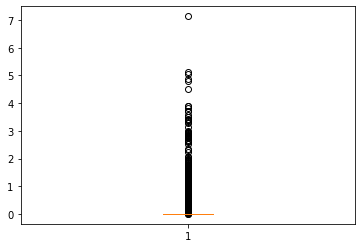

Mean: 0.18474462073462292
Median: 0.0
Variance: 0.2820297163506549
Range: 9.09


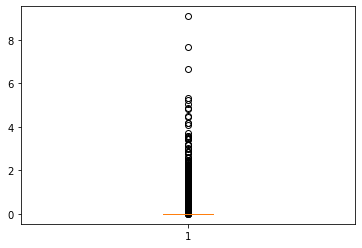

Mean: 1.662099543577483
Median: 1.31
Variance: 3.1516464504257864
Range: 18.75


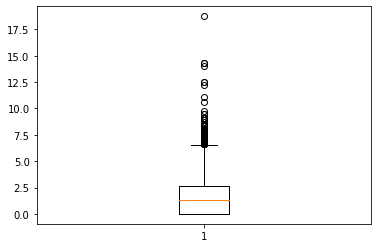

Mean: 0.0855770484677244
Median: 0.0
Variance: 0.25980580155103633
Range: 18.18


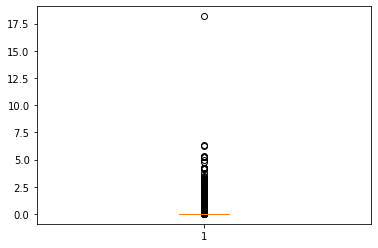

Mean: 0.809760921538796
Median: 0.22
Variance: 1.44163080569739
Range: 11.11


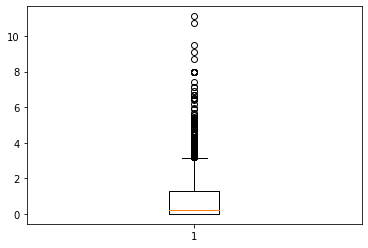

Mean: 0.12120191262768963
Median: 0.0
Variance: 1.0519458494725427
Range: 17.1


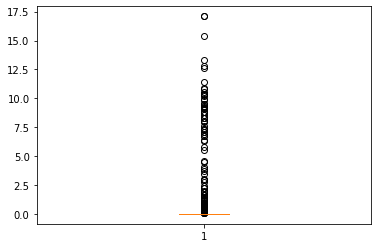

Mean: 0.1016452945011954
Median: 0.0
Variance: 0.12267390678561746
Range: 5.45


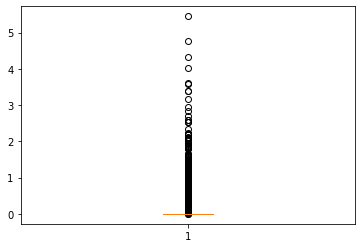

Mean: 0.09426863725277114
Median: 0.0
Variance: 0.19588362616047722
Range: 12.5


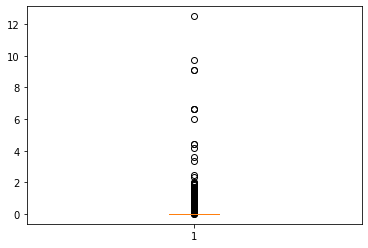

Mean: 0.5495044555531406
Median: 0.0
Variance: 2.792801493188146
Range: 20.83


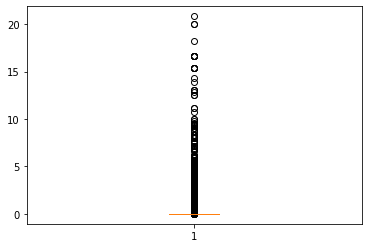

Mean: 0.2653836122582047
Median: 0.0
Variance: 0.786518788942483
Range: 16.66


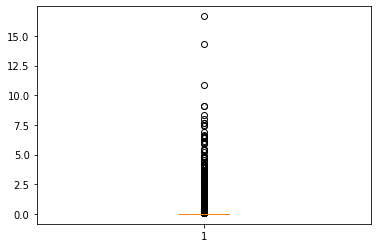

Mean: 0.767304933710063
Median: 0.0
Variance: 11.336189693800916
Range: 33.33


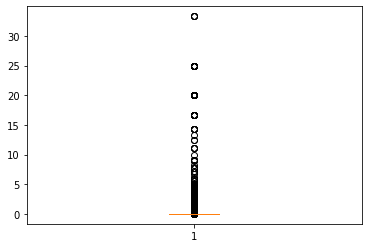

Mean: 0.12484459900021737
Median: 0.0
Variance: 0.29000111147322
Range: 9.09


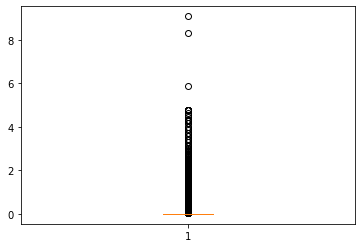

Mean: 0.09891545316235603
Median: 0.0
Variance: 0.35195994090660293
Range: 14.28


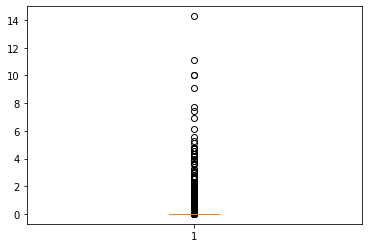

Mean: 0.10285155400999783
Median: 0.0
Variance: 0.20851271193466392
Range: 5.88


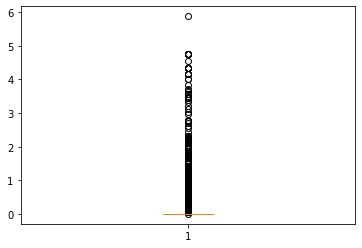

Mean: 0.06475331449684851
Median: 0.0
Variance: 0.16269014236295457
Range: 12.5


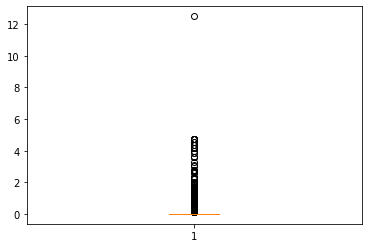

Mean: 0.047048467724407746
Median: 0.0
Variance: 0.10792747624249022
Range: 4.76


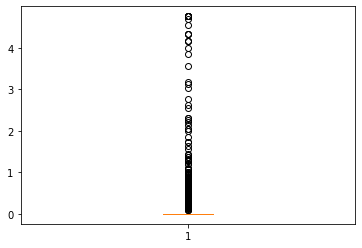

Mean: 0.097228863290589
Median: 0.0
Variance: 0.30896565268571075
Range: 18.18


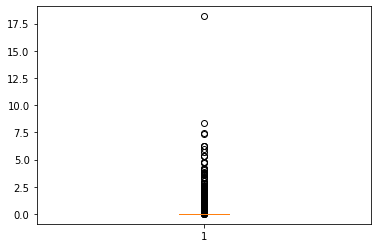

Mean: 0.04783525320582482
Median: 0.0
Variance: 0.10851063662723974
Range: 4.76


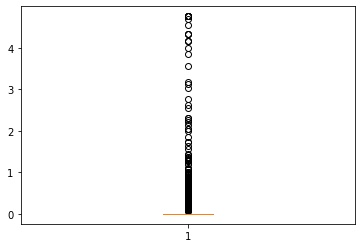

Mean: 0.10541186698543796
Median: 0.0
Variance: 0.2832390011980141
Range: 20.0


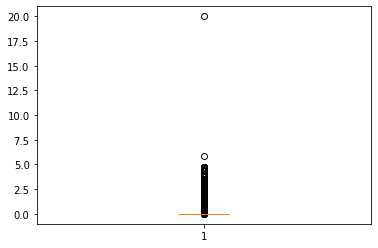

Mean: 0.0974766355140187
Median: 0.0
Variance: 0.16207015947366177
Range: 7.69


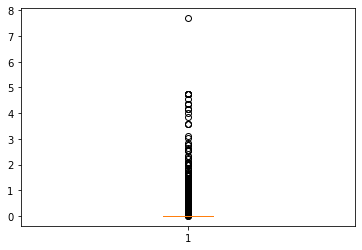

Mean: 0.1369528363399261
Median: 0.0
Variance: 0.17927208840806036
Range: 6.89


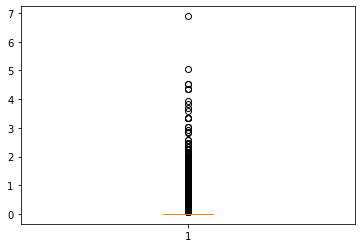

Mean: 0.013201477939578352
Median: 0.0
Variance: 0.04867618826993046
Range: 8.33


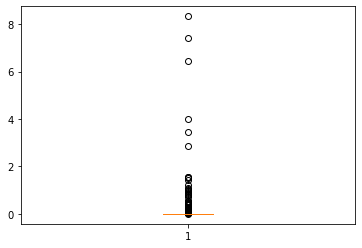

Mean: 0.07862855900891111
Median: 0.0
Variance: 0.18889872771296373
Range: 11.11


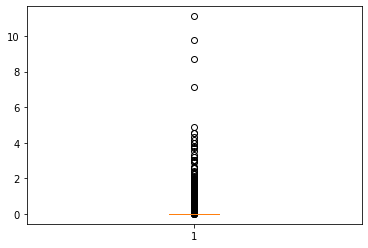

Mean: 0.06483373179743533
Median: 0.0
Variance: 0.12241458330902523
Range: 4.76


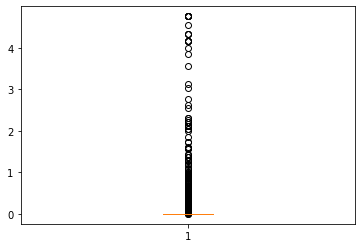

Mean: 0.043666594218648117
Median: 0.0
Variance: 0.1304404791470401
Range: 7.14


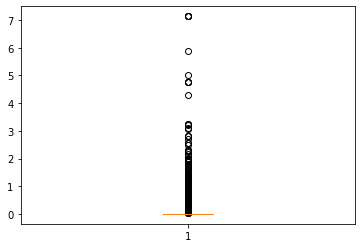

Mean: 0.13233862203868726
Median: 0.0
Variance: 0.5878842504731283
Range: 14.28


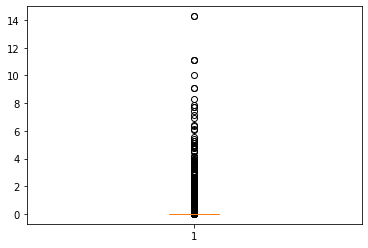

Mean: 0.0460986742012606
Median: 0.0
Variance: 0.05008082399519944
Range: 3.57


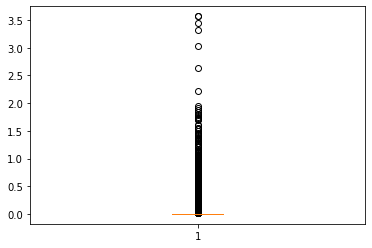

Mean: 0.0791958269941317
Median: 0.0
Variance: 0.3867695337013428
Range: 20.0


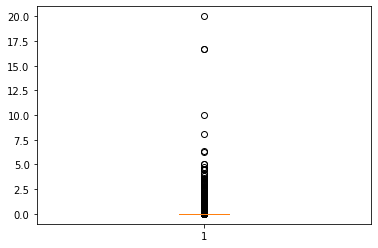

Mean: 0.30122364703325366
Median: 0.0
Variance: 1.023288591799001
Range: 21.42


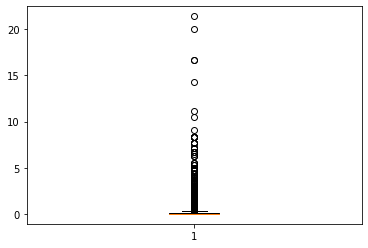

Mean: 0.17982395131493156
Median: 0.0
Variance: 0.8299575217127938
Range: 22.05


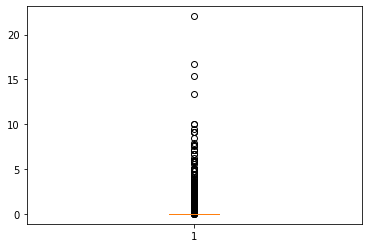

Mean: 0.005444468593783961
Median: 0.0
Variance: 0.005816499904743688
Range: 2.17


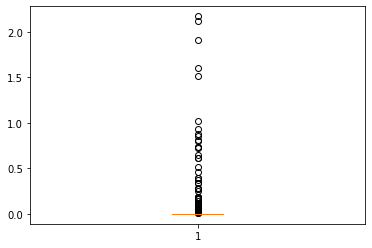

Mean: 0.03186915887850467
Median: 0.0
Variance: 0.08162654319357636
Range: 10.0


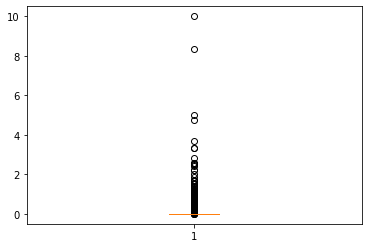

Mean: 0.038574657683112364
Median: 0.0
Variance: 0.059265403739423135
Range: 4.385


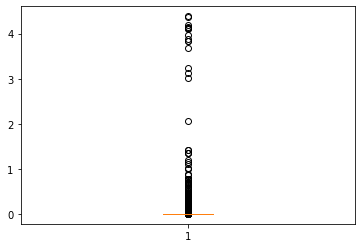

Mean: 0.13903042816778963
Median: 0.065
Variance: 0.07307614208651522
Range: 9.752


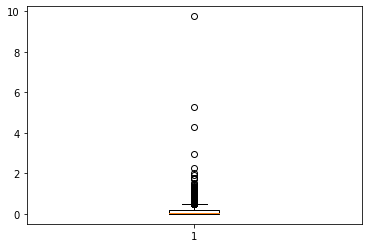

Mean: 0.01697587480982395
Median: 0.0
Variance: 0.011964482139122776
Range: 4.081


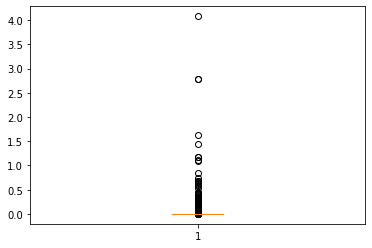

Mean: 0.26907085416213866
Median: 0.0
Variance: 0.6651756063685162
Range: 32.478


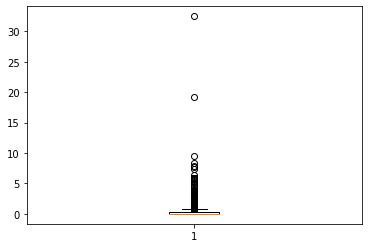

Mean: 0.0758106933275375
Median: 0.0
Variance: 0.0604448233240357
Range: 6.003


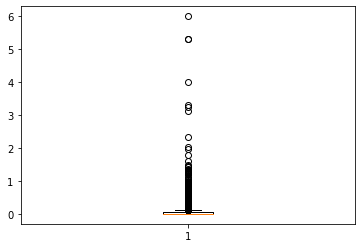

Mean: 0.04423820908498152
Median: 0.0
Variance: 0.18429456442574288
Range: 19.829


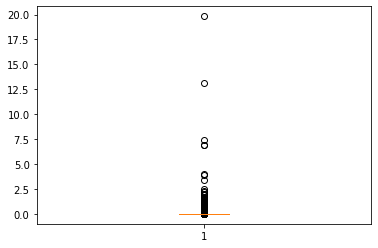

Mean: 5.191515105411866
Median: 2.276
Variance: 1006.5391045088458
Range: 1101.5


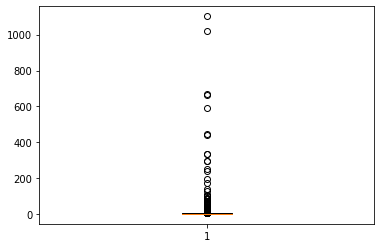

Mean: 52.17278852423386
Median: 15.0
Variance: 37974.36723171554
Range: 9988.0


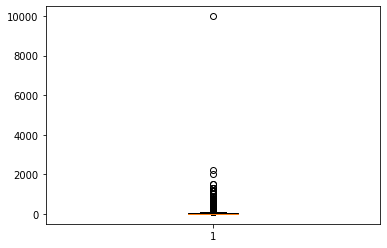

Mean: 283.28928493805694
Median: 95.0
Variance: 367577.8078595409
Range: 15840.0


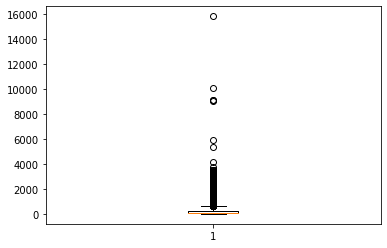

In [9]:

for i in range(df.shape[1]-1):
    
    # Get all values of the feature i
    values = df_np[:, i]
    
    print("Mean:", mean(values))
    print("Median:", median(values))
    print("Variance:", var(values))
    print("Range:", max(values) - min(values))
    #quartiles ?
    
    plt.boxplot(values)
    plt.show()


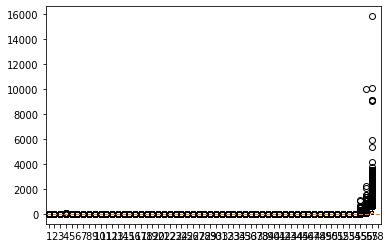

In [10]:
plt.boxplot(df)
plt.show()

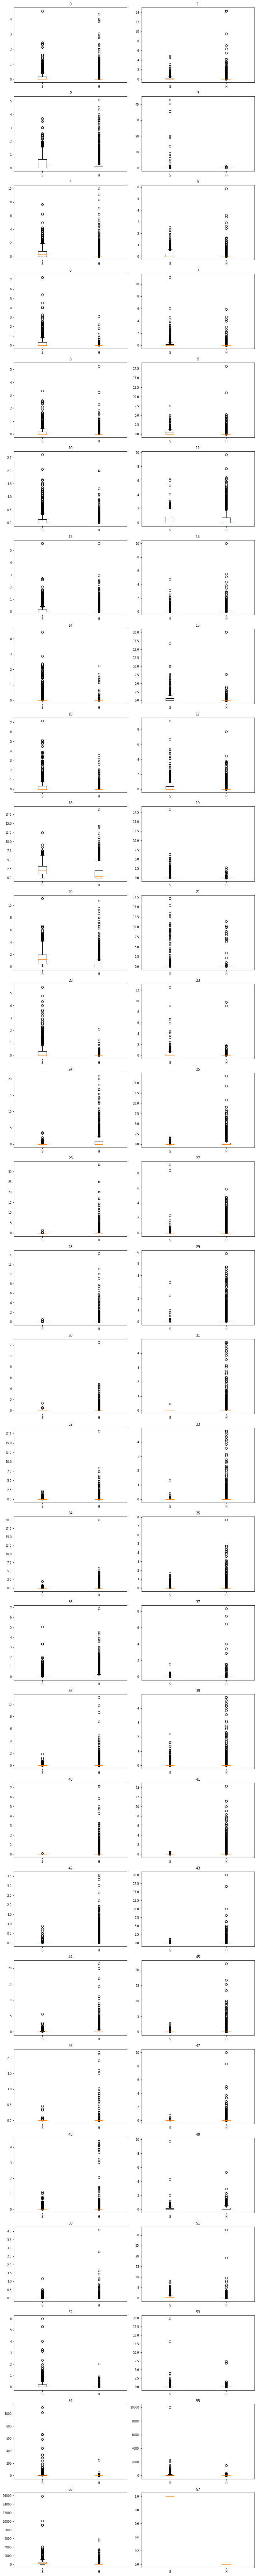

In [11]:
dfS=df[df[57] ==1]
dfH=df[df[57] ==0]
#Creating the window with 10 subplots.
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=29, ncols=2, figsize=(10,100))
axes = axes.ravel()
#BOXPLOTS
for idx,ax in enumerate(axes):
    ax.figure
    data_to_plot = [dfS[idx],dfH[idx]]
    ax.boxplot(data_to_plot)
    ax.set_xticklabels(['S', 'H'])
    ax.set_title(idx)
plt.tight_layout()
plt.show()    

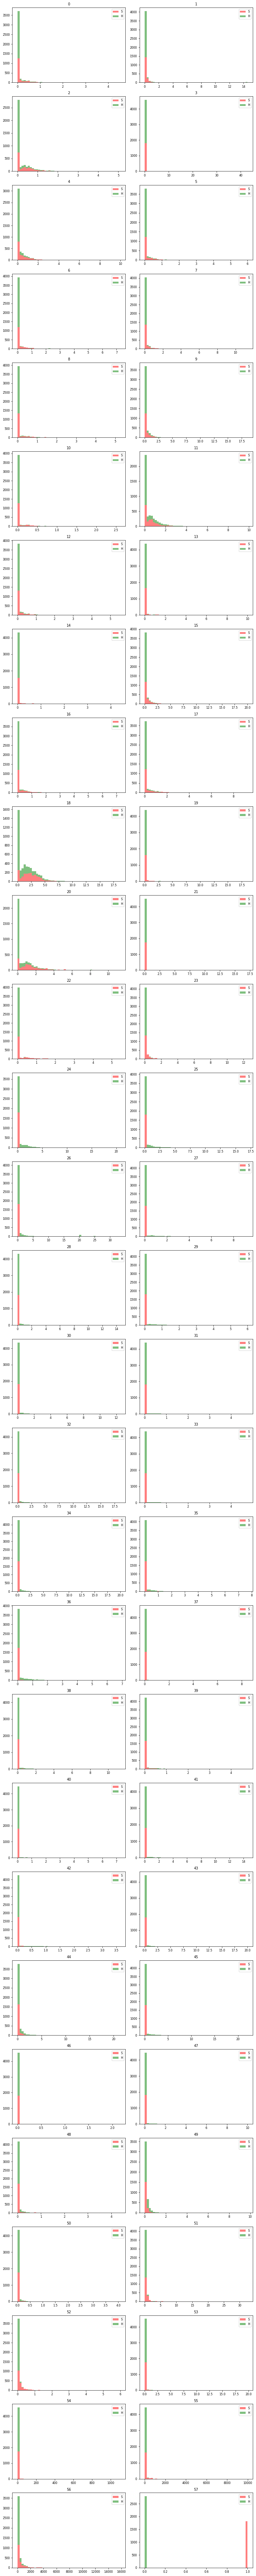

In [12]:
# Separating the data 
dfS=df[df[57] ==1]
dfH=df[df[57] ==0]
#Creating the window with 10 subplots.
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=29, ncols=2, figsize=(10,100))
axes = axes.ravel()
#Creating histograms with 50 bins
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[idx]) - min(df[idx]))/50
    ax.hist([dfS[idx],dfH[idx]], bins=np.arange(min(df[idx]), max(df[idx]) + binwidth, binwidth) , alpha=0.5,stacked=True, label=['S','H'],color=['r','g']) #remove density=True to remove probs in y axis
    ax.legend(loc='upper right')
    ax.set_title(idx)
plt.tight_layout()
plt.show()

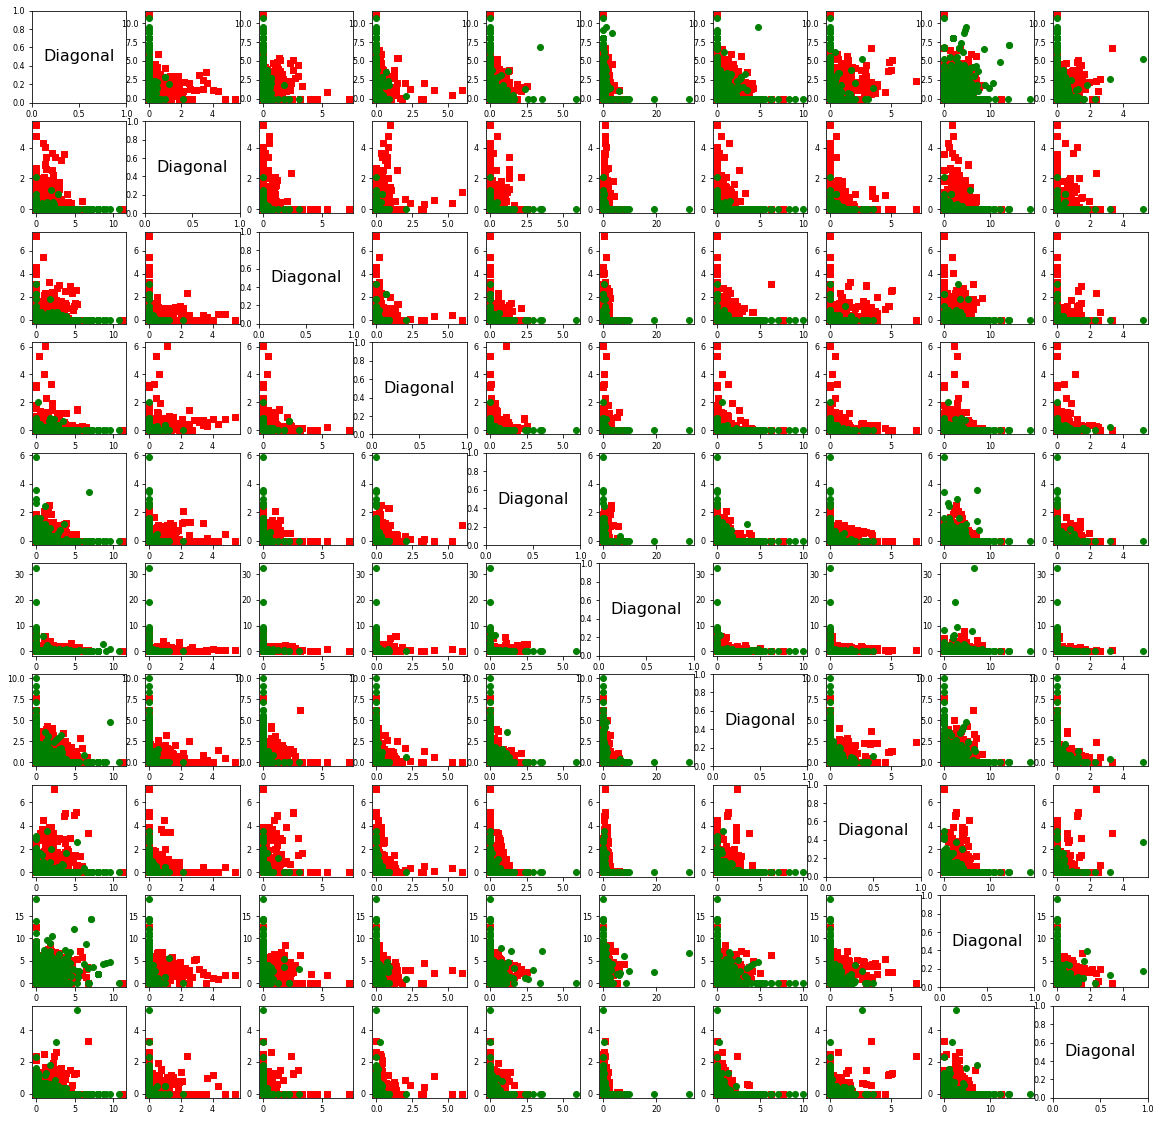

In [13]:
dfS=df[df[57] ==1]
dfH=df[df[57] ==0]
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))
#fig, axes = plt.subplots(nrows=d, ncols=d, sharex=True, sharey=True)

top_10_features = [20, 22, 6, 52, 5, 51, 4, 16, 18, 8]

for i in range(10):
    for j in range(10):
        ax = axes[i,j]
        ax.figure
        if i == j:
            ax.text(0.5, 0.5, "Diagonal", transform=ax.transAxes,
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=16)
        else:
            ax.scatter(dfS[top_10_features[j]],dfS[top_10_features[i]],marker='s',color='r',label='S')  
            #hold(True)
            ax.scatter(dfH[top_10_features[j]],dfH[top_10_features[i]],marker='o',color='g',label='H')    

       
           
plt.show()

In [14]:
# Matrix to store all pearsons correlations values
pearsons_correlations = np.empty([57, 57])

for i in range(0, df.shape[1]-1):
    for k in range(i+1, df.shape[1]-1):
        
        # Calculate Pearson's correlation between feature i and k
        corr, _ = pearsonr(df_np[:, i], df_np[:, k])
        
        # Store the value in matrix
        pearsons_correlations[i, k] = corr
        pearsons_correlations[k, i] = corr
        
        print("Pearsons correlation between {0} and {1}: {2}".format(i, k, corr))
        
pearsons_correlations

Pearsons correlation between 0 and 1: -0.016759465965112526
Pearsons correlation between 0 and 2: 0.06562676741246644
Pearsons correlation between 0 and 3: 0.013273232168107524
Pearsons correlation between 0 and 4: 0.023118630601867165
Pearsons correlation between 0 and 5: 0.05967433812016053
Pearsons correlation between 0 and 6: 0.007668553072690656
Pearsons correlation between 0 and 7: -0.003949886838921879
Pearsons correlation between 0 and 8: 0.106262978895582
Pearsons correlation between 0 and 9: 0.04119770210863794
Pearsons correlation between 0 and 10: 0.1884586382769463
Pearsons correlation between 0 and 11: 0.10580100402791734
Pearsons correlation between 0 and 12: 0.06643817776869967
Pearsons correlation between 0 and 13: 0.03678048907348532
Pearsons correlation between 0 and 14: 0.02843879479885183
Pearsons correlation between 0 and 15: 0.05938565344264984
Pearsons correlation between 0 and 16: 0.08192807076096431
Pearsons correlation between 0 and 17: 0.0533235331746644
Pea

Pearsons correlation between 23 and 39: -0.02294648986722593
Pearsons correlation between 23 and 40: -0.02570252628624585
Pearsons correlation between 23 and 41: -0.03414628715880571
Pearsons correlation between 23 and 42: -0.03917236981299458
Pearsons correlation between 23 and 43: -0.023522077011220714
Pearsons correlation between 23 and 44: -0.04592223467723828
Pearsons correlation between 23 and 45: -0.03140140431628264
Pearsons correlation between 23 and 46: -0.010457754798174618
Pearsons correlation between 23 and 47: -0.019170991237300185
Pearsons correlation between 23 and 48: -0.019139227823742645
Pearsons correlation between 23 and 49: -0.03311326469474597
Pearsons correlation between 23 and 50: -0.02079831091314571
Pearsons correlation between 23 and 51: 0.0510759116163932
Pearsons correlation between 23 and 52: 0.10469130911880467
Pearsons correlation between 23 and 53: 0.0007029468720546377
Pearsons correlation between 23 and 54: 0.007681086705293191
Pearsons correlation b

array([[ 6.92624221e-310, -1.67594660e-002,  6.56267674e-002, ...,
         4.44908619e-002,  6.13824005e-002,  8.91647776e-002],
       [-1.67594660e-002,  0.00000000e+000, -3.35256801e-002, ...,
         2.08284230e-003,  2.71204180e-004, -2.26796974e-002],
       [ 6.56267674e-002, -3.35256801e-002,  0.00000000e+000, ...,
         9.73980411e-002,  1.07462733e-001,  7.01135857e-002],
       ...,
       [ 4.44908619e-002,  2.08284230e-003,  9.73980411e-002, ...,
         4.63935496e-310,  4.92638297e-001,  1.62313609e-001],
       [ 6.13824005e-002,  2.71204180e-004,  1.07462733e-001, ...,
         4.92638297e-001,  3.50485815e+002,  4.75485956e-001],
       [ 8.91647776e-002, -2.26796974e-002,  7.01135857e-002, ...,
         1.62313609e-001,  4.75485956e-001,  2.37151510e-322]])

(57, 57)


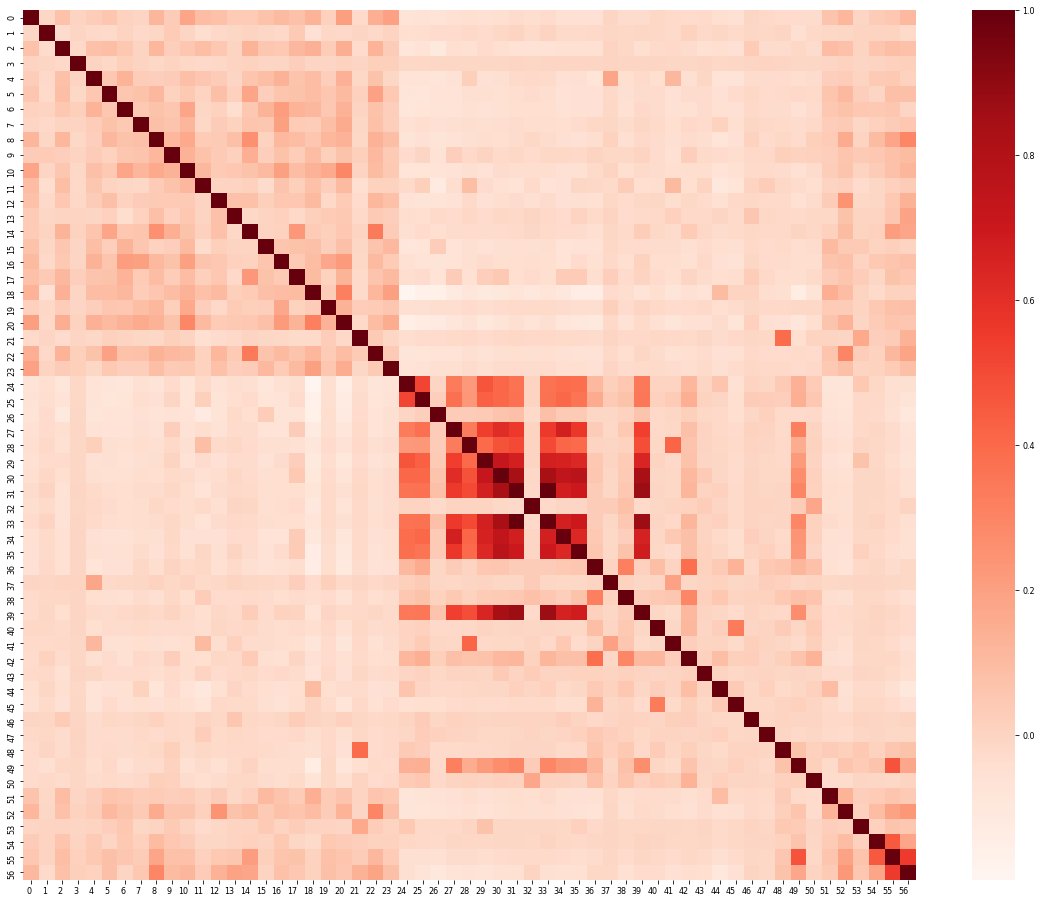

In [25]:
# Using numpy software.  Another comand in PANDAS (see latter)
corr = np.corrcoef(X_train.T) # This should be done with training data
print(corr.shape)

plt.figure(figsize=(20,16))

ax = sns.heatmap(corr, cmap=plt.cm.Reds)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
    horizontalalignment='right'
);
plt.show()

In [ ]:
# Correlation Matrix
corr = df.corr()

sns.set(rc = {'figure.figsize':(30,16)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Normalization z-score

In [ ]:
print(df_np)
for i in range(df.shape[1]-1):
    feature_data = df_np[:, [i]]
    df_np[:, [i]] = ( feature_data - df.describe()[i]["mean"] ) / df.describe()[i]["std"]

print(df_np)